In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import datetime

# ================= 配置 =================
DPI = 150
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Hei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False

# ================= 1. 稳健的路径定位 =================
def find_project_root(current_path, marker='results'):
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)):
        return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError()
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
    print(f"✅ 定位根目录: {PROJECT_ROOT}")
except:
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB-Spread-Regime'
    print(f"⚠️ 使用硬编码路径: {PROJECT_ROOT}")

# 文件路径
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time.parquet')
SHAP_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time_shap.npy')

FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 
    'Depth_Change', 'LobImbalance', 'DeepLobImbalance', 
    'Relative_Spread', 'Micro_Mid_Spread', 'PastReturn', 
    'Lambda', 'Volatility', 'AutoCov'
]

# ================= 2. 加载数据与缓存 =================
if not os.path.exists(DATA_PATH) or not os.path.exists(SHAP_PATH):
    raise FileNotFoundError("找不到数据或SHAP缓存，请先运行 scripts/make_fast_sample.py")

print(f">>> 正在加载数据: {DATA_PATH}")
df = pd.read_parquet(DATA_PATH)
if 'Time' in df.columns: df['Time'] = pd.to_datetime(df['Time'])

print(f">>> 正在加载预计算SHAP值: {SHAP_PATH}")
shap_values_all = np.load(SHAP_PATH)

# 严谨性检查：确保行数一致
assert len(df) == shap_values_all.shape[0], "数据行数与SHAP矩阵行数不匹配！"
print(f"✅ 加载成功。样本数: {len(df)}")

# ================= 3. 极速绘图函数 =================
def plot_precalculated_interaction(subset_df, subset_shap, ax, title):
    """
    直接使用切分好的 DataFrame 和 SHAP 矩阵绘图，无需重新计算。
    """
    print(f"   -> 正在绘制: {title} (N={len(subset_df)}) ...")
    
    # 1. 去极值逻辑 (Micro_Mid_Spread 掐头去尾 1%)
    col_name = 'Micro_Mid_Spread'
    lower_bound = subset_df[col_name].quantile(0.005)
    upper_bound = subset_df[col_name].quantile(0.995)
    
    # 创建布尔掩码 (Mask)
    mask_filter = (subset_df[col_name] >= lower_bound) & (subset_df[col_name] <= upper_bound)
    
    # 应用掩码到 DF 和 SHAP 矩阵
    df_clean = subset_df[mask_filter]
    shap_clean = subset_shap[mask_filter]
    
    # 2. 提取需要的数据
    x_val = df_clean['LobImbalance']
    y_val = df_clean['Micro_Mid_Spread']
    
    idx_x = FEATURE_COLS.index('LobImbalance')
    idx_y = FEATURE_COLS.index('Micro_Mid_Spread')
    
    # 提取颜色 (交互值 * 2)
    c_val = shap_clean[:, idx_x, idx_y] * 2
    
    # 3. 动态颜色范围
    c_max = np.percentile(np.abs(c_val), 98)
    
    # 4. 绘图
    sc = ax.scatter(
        x=x_val, y=y_val, c=c_val,
        cmap='seismic', s=5, alpha=0.6,
        vmin=-c_max, vmax=c_max, edgecolor='none'
    )
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('LobImbalance', fontsize=10)
    ax.set_ylabel('Micro_Mid_Spread (Filtered)', fontsize=10)
    ax.axhline(0, c='black', ls=':', alpha=0.4)
    ax.axvline(0, c='black', ls=':', alpha=0.4)
    ax.grid(True, linestyle=':', alpha=0.3)
    
    return sc

✅ 定位根目录: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime
>>> 正在加载数据: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/data/processed/sample_with_time.parquet
>>> 正在加载预计算SHAP值: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/data/processed/sample_with_time_shap.npy
✅ 加载成功。样本数: 10000



>>> Running Intraday Stability Check (Instant Mode)...
    Morning Samples: 5656
    Afternoon Samples: 4344
   -> 正在绘制: AM Session (09:30-11:30) (N=5656) ...
   -> 正在绘制: PM Session (13:00-15:00) (N=4344) ...


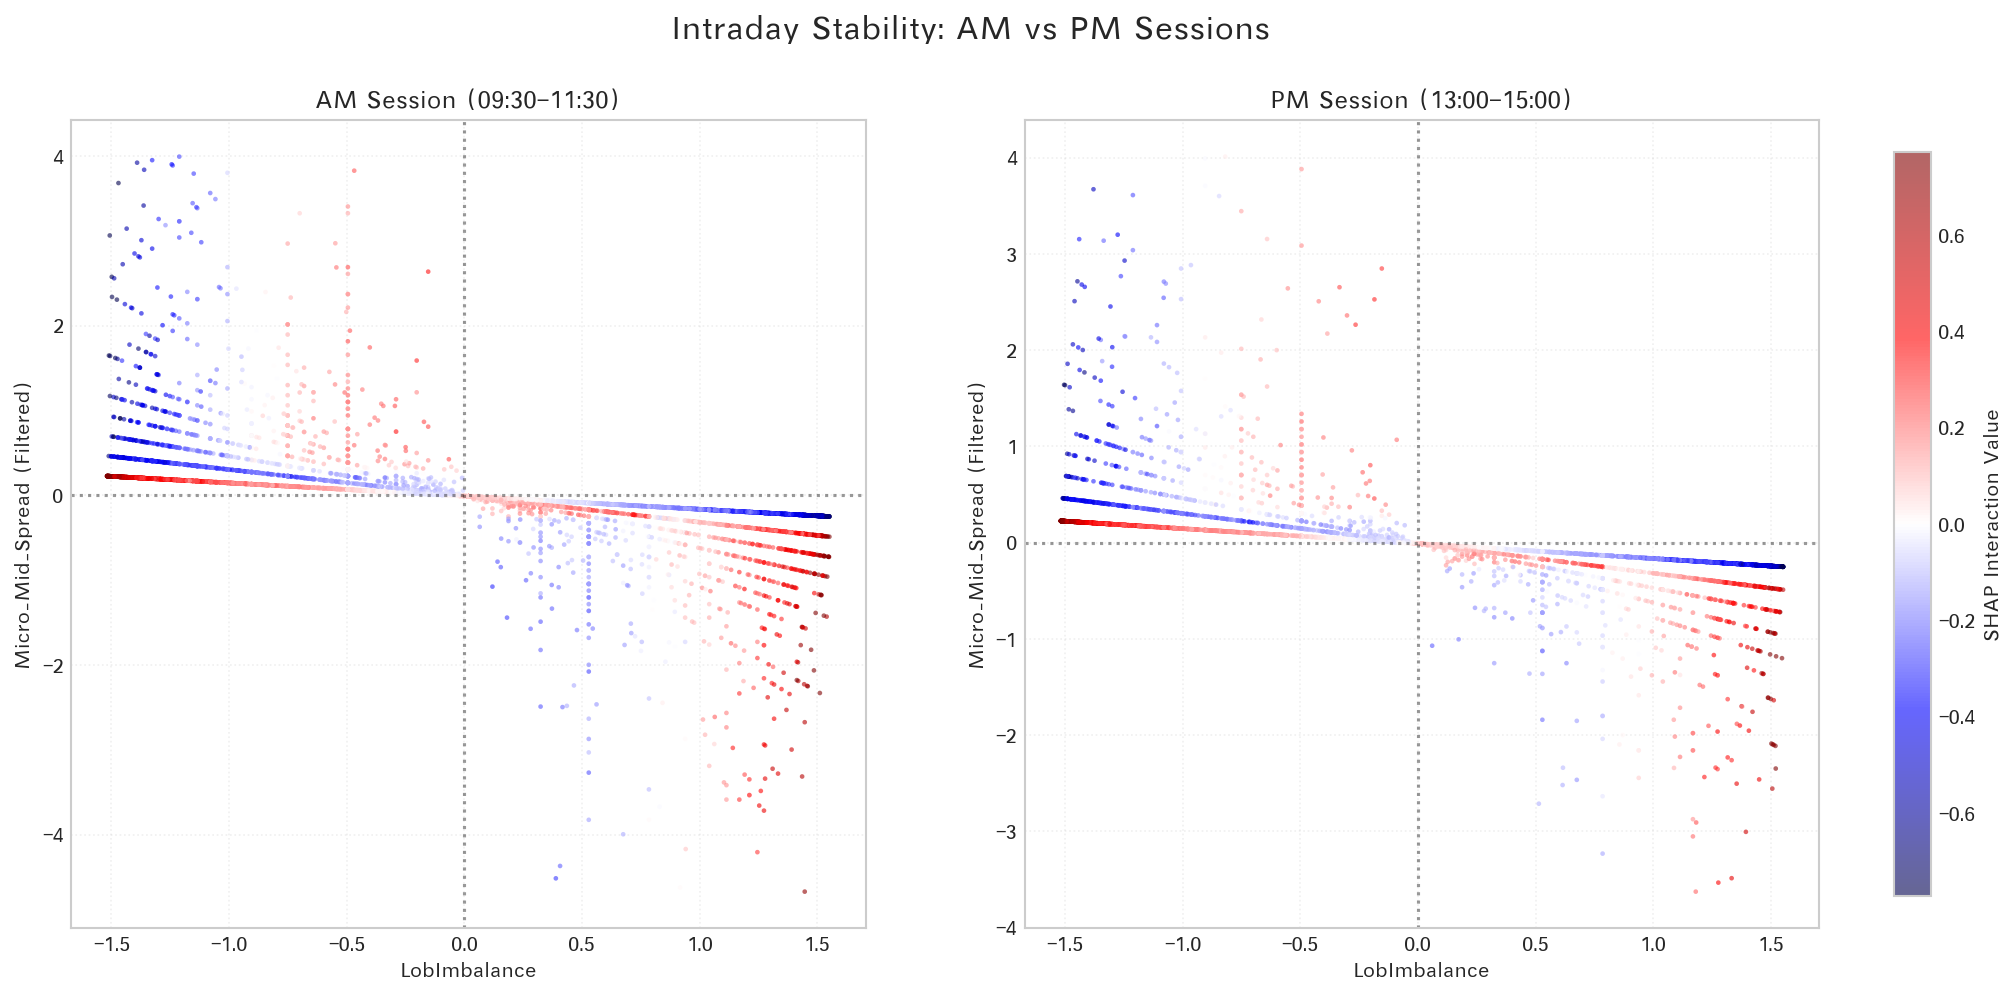

    ✅ 图表已保存: /Users/day/Desktop/书架/大三上/LOB-Spread-Regime/results/figures/02_Stability_Intraday.png


In [12]:
# ================= 4. 实验: 日内稳定性 (AM vs PM) =================
print("\n>>> Running Intraday Stability Check (Instant Mode)...")

if 'Time' in df.columns:
    times = df['Time'].dt.time
    
    # 1. 定义切分掩码 (Mask)
    mask_am = times <= datetime.time(11, 30)
    mask_pm = times >= datetime.time(13, 0)
    
    # 2. 利用掩码同时切分 数据集 和 SHAP矩阵
    # 这是最关键的一步：保持索引对齐
    df_am = df[mask_am]
    shap_am = shap_values_all[mask_am]
    
    df_pm = df[mask_pm]
    shap_pm = shap_values_all[mask_pm]
    
    print(f"    Morning Samples: {len(df_am)}")
    print(f"    Afternoon Samples: {len(df_pm)}")
    
    if len(df_am) > 0 and len(df_pm) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=DPI)
        
        # 直接传入切分好的数据和SHAP矩阵
        plot_precalculated_interaction(df_am, shap_am, axes[0], "AM Session (09:30-11:30)")
        sc = plot_precalculated_interaction(df_pm, shap_pm, axes[1], "PM Session (13:00-15:00)")
        
        cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('SHAP Interaction Value', fontsize=10)
        
        plt.suptitle("Intraday Stability: AM vs PM Sessions", fontsize=16)
        
        save_path = os.path.join(PROJECT_ROOT, 'results', 'figures', '02_Stability_Intraday.png')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        plt.savefig(save_path, dpi=300)
        plt.show()
        print(f"    ✅ 图表已保存: {save_path}")
    else:
        print("    ⚠️ 数据不足。")
else:
    print("    ⚠️ 缺少 Time 列。")

In [13]:
from scipy.stats import pearsonr

# ================= 5. 定量验证: 数字化你的“肉眼观察” =================
print("\n>>> Running Quantitative Stability Metrics...")

# 1. 准备数据: 提取目标交互值
idx_x = FEATURE_COLS.index('LobImbalance')
idx_y = FEATURE_COLS.index('Micro_Mid_Spread')

# 提取 AM 和 PM 的交互效应 (乘以2因为交互矩阵是对称的)
# 注意：复用上一个单元格生成的 df_am, shap_am 等变量
interaction_am = shap_am[:, idx_x, idx_y] * 2
interaction_pm = shap_pm[:, idx_x, idx_y] * 2

# 将交互值拼回到 DataFrame 以便分组聚合
df_am_metric = df_am.copy()
df_am_metric['SHAP_Interaction'] = interaction_am

df_pm_metric = df_pm.copy()
df_pm_metric['SHAP_Interaction'] = interaction_pm

# ------------------------------------------------------------------
# 指标 A: 网格化全局相关性 (Global Pattern Correlation)
# 逻辑: 把 2D 散点看作 20x20 的像素图，对比两张图的相似度
# ------------------------------------------------------------------

# 定义统一的网格边界 (使用全量数据的范围，确保 AM/PM 网格对齐)
x_min, x_max = df['LobImbalance'].min(), df['LobImbalance'].max()
y_min, y_max = df['Micro_Mid_Spread'].min(), df['Micro_Mid_Spread'].max()
bins_num = 20

x_bins = np.linspace(x_min, x_max, bins_num + 1)
y_bins = np.linspace(y_min, y_max, bins_num + 1)

def get_grid_vector(sub_df):
    """将数据映射到 20x20 网格并展平为向量"""
    sub_df['x_bin'] = pd.cut(sub_df['LobImbalance'], bins=x_bins, labels=False)
    sub_df['y_bin'] = pd.cut(sub_df['Micro_Mid_Spread'], bins=y_bins, labels=False)
    
    # 计算每个网格内的平均 SHAP 值
    grid_map = sub_df.groupby(['x_bin', 'y_bin'])['SHAP_Interaction'].mean()
    
    # 构造完整矩阵 (填补空缺网格为0)
    matrix = np.zeros((bins_num, bins_num))
    for (r, c), val in grid_map.items():
        if pd.notnull(r) and pd.notnull(c):
            matrix[int(r), int(c)] = val
            
    return matrix.flatten()

vec_am = get_grid_vector(df_am_metric)
vec_pm = get_grid_vector(df_pm_metric)

# 计算皮尔逊相关系数
correlation, _ = pearsonr(vec_am, vec_pm)

# ------------------------------------------------------------------
# 指标 B: 符号一致率 (Sign Consistency Ratio)
# 逻辑: 统计有多少网格在上午和下午的方向(红/蓝)是一致的
# ------------------------------------------------------------------

# 只考虑信号较强的区域 (忽略接近0的噪音)
threshold = 1e-5
valid_mask = (np.abs(vec_am) > threshold) | (np.abs(vec_pm) > threshold)

# 计算符号是否相同
sign_match = np.sign(vec_am[valid_mask]) == np.sign(vec_pm[valid_mask])
sign_ratio = np.mean(sign_match)

# ------------------------------------------------------------------
# 指标 C: 关键状态斜率差异 (Regime Slope Difference)
# 逻辑: 验证 "小Spread=动量" 和 "大Spread=反转" 的物理定律是否改变
# ------------------------------------------------------------------

def get_regime_slope(sub_df, regime_type):
    """计算特定区域内 SHAP ~ Imbalance 的斜率"""
    # 定义区域阈值 (按绝对值分位数)
    low_th = df['Micro_Mid_Spread'].abs().quantile(0.2)  # 模拟 Spread=1
    high_th = df['Micro_Mid_Spread'].abs().quantile(0.6) # 模拟 Spread>=2
    
    if regime_type == 'tight':
        subset = sub_df[sub_df['Micro_Mid_Spread'].abs() < low_th]
    else:
        subset = sub_df[sub_df['Micro_Mid_Spread'].abs() > high_th]
        
    if len(subset) < 10: return 0
    
    # 简单线性回归 slope
    return np.polyfit(subset['LobImbalance'], subset['SHAP_Interaction'], 1)[0]

# 计算 AM 的斜率
slope_am_tight = get_regime_slope(df_am_metric, 'tight')
slope_am_wide = get_regime_slope(df_am_metric, 'wide')

# 计算 PM 的斜率
slope_pm_tight = get_regime_slope(df_pm_metric, 'tight')
slope_pm_wide = get_regime_slope(df_pm_metric, 'wide')

# ================= 6. 打印学术级报告 =================
print("\n" + "="*60)
print("   Quantitative Robustness Report (定量稳定性报告)")
print("="*60)

print(f"\n[Metric 1] Global Pattern Correlation (全局模式相关性)")
print(f"   Value: {correlation:.4f}")
print(f"   Eval : {'Excellent (>0.8)' if correlation > 0.8 else 'Good (>0.6)' if correlation > 0.6 else 'Weak'}")
print(f"   -> 证明上午和下午的微观结构“地形图”高度相似。")

print(f"\n[Metric 2] Sign Consistency Ratio (符号一致率)")
print(f"   Value: {sign_ratio:.2%}")
print(f"   -> 证明在 {sign_ratio:.1%} 的有效区域内，博弈方向(动量/反转)未发生改变。")

print(f"\n[Metric 3] Regime Slope Stability (关键机制斜率)")
print(f"   {'Region':<15} | {'AM Slope':<10} | {'PM Slope':<10} | {'Status'}")
print(f"   {'-'*50}")
status_tight = "✅ Stable" if np.sign(slope_am_tight) == np.sign(slope_pm_tight) else "⚠️ Changed"
print(f"   {'Tight (Spread=1)':<15} | {slope_am_tight:+.4f}     | {slope_pm_tight:+.4f}     | {status_tight}")

status_wide = "✅ Stable" if np.sign(slope_am_wide) == np.sign(slope_pm_wide) else "⚠️ Changed"
print(f"   {'Wide (Spread>=2)':<15} | {slope_am_wide:+.4f}     | {slope_pm_wide:+.4f}     | {status_wide}")

print(f"\n   -> Tight区应为正(动量)，Wide区应为负(反转)。")
print("="*60)


>>> Running Quantitative Stability Metrics...

   Quantitative Robustness Report (定量稳定性报告)

[Metric 1] Global Pattern Correlation (全局模式相关性)
   Value: 0.6659
   Eval : Good (>0.6)
   -> 证明上午和下午的微观结构“地形图”高度相似。

[Metric 2] Sign Consistency Ratio (符号一致率)
   Value: 66.67%
   -> 证明在 66.7% 的有效区域内，博弈方向(动量/反转)未发生改变。

[Metric 3] Regime Slope Stability (关键机制斜率)
   Region          | AM Slope   | PM Slope   | Status
   --------------------------------------------------
   Tight (Spread=1) | -0.0404     | -0.0439     | ✅ Stable
   Wide (Spread>=2) | +0.0625     | +0.0125     | ✅ Stable

   -> Tight区应为正(动量)，Wide区应为负(反转)。


>>> Loading Data...

>>> Executing Dual-Peak Calibration...
   [Detection] Found 2 candidate peaks at: [0.1475 0.3175]
   [Diagnosis] Detected SINGLE DOMINANT PEAK.
   [Strategy ] Using MAX PEAK as Base Slope: 0.1475


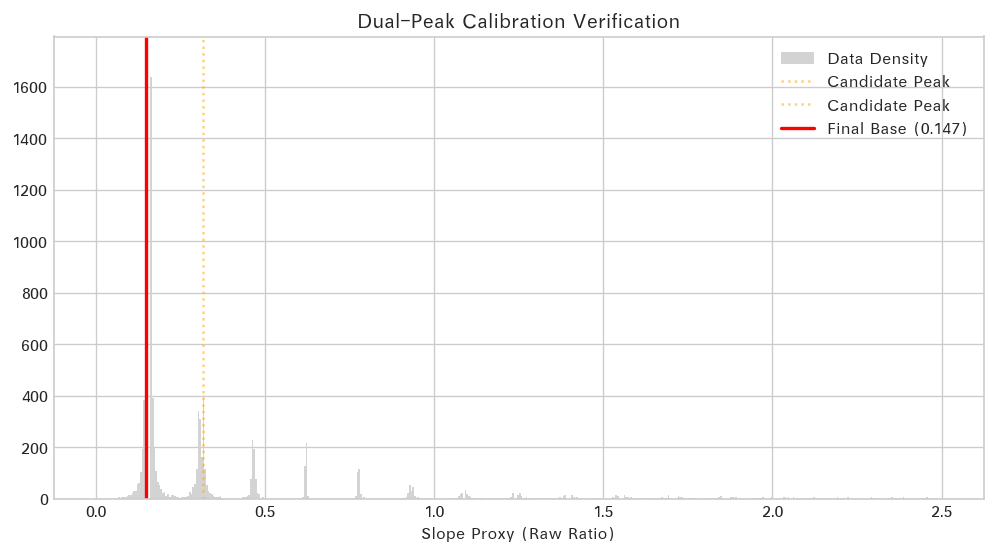


   [Distribution] Final Group Counts:
Ray_Group
Ray 1 (Spread=1)     5213
Ray 3 (Spread>=3)    2332
Ray 2 (Spread=2)     1812
Noise                   8
Name: count, dtype: int64

>>> Generating Mechanism Curves...


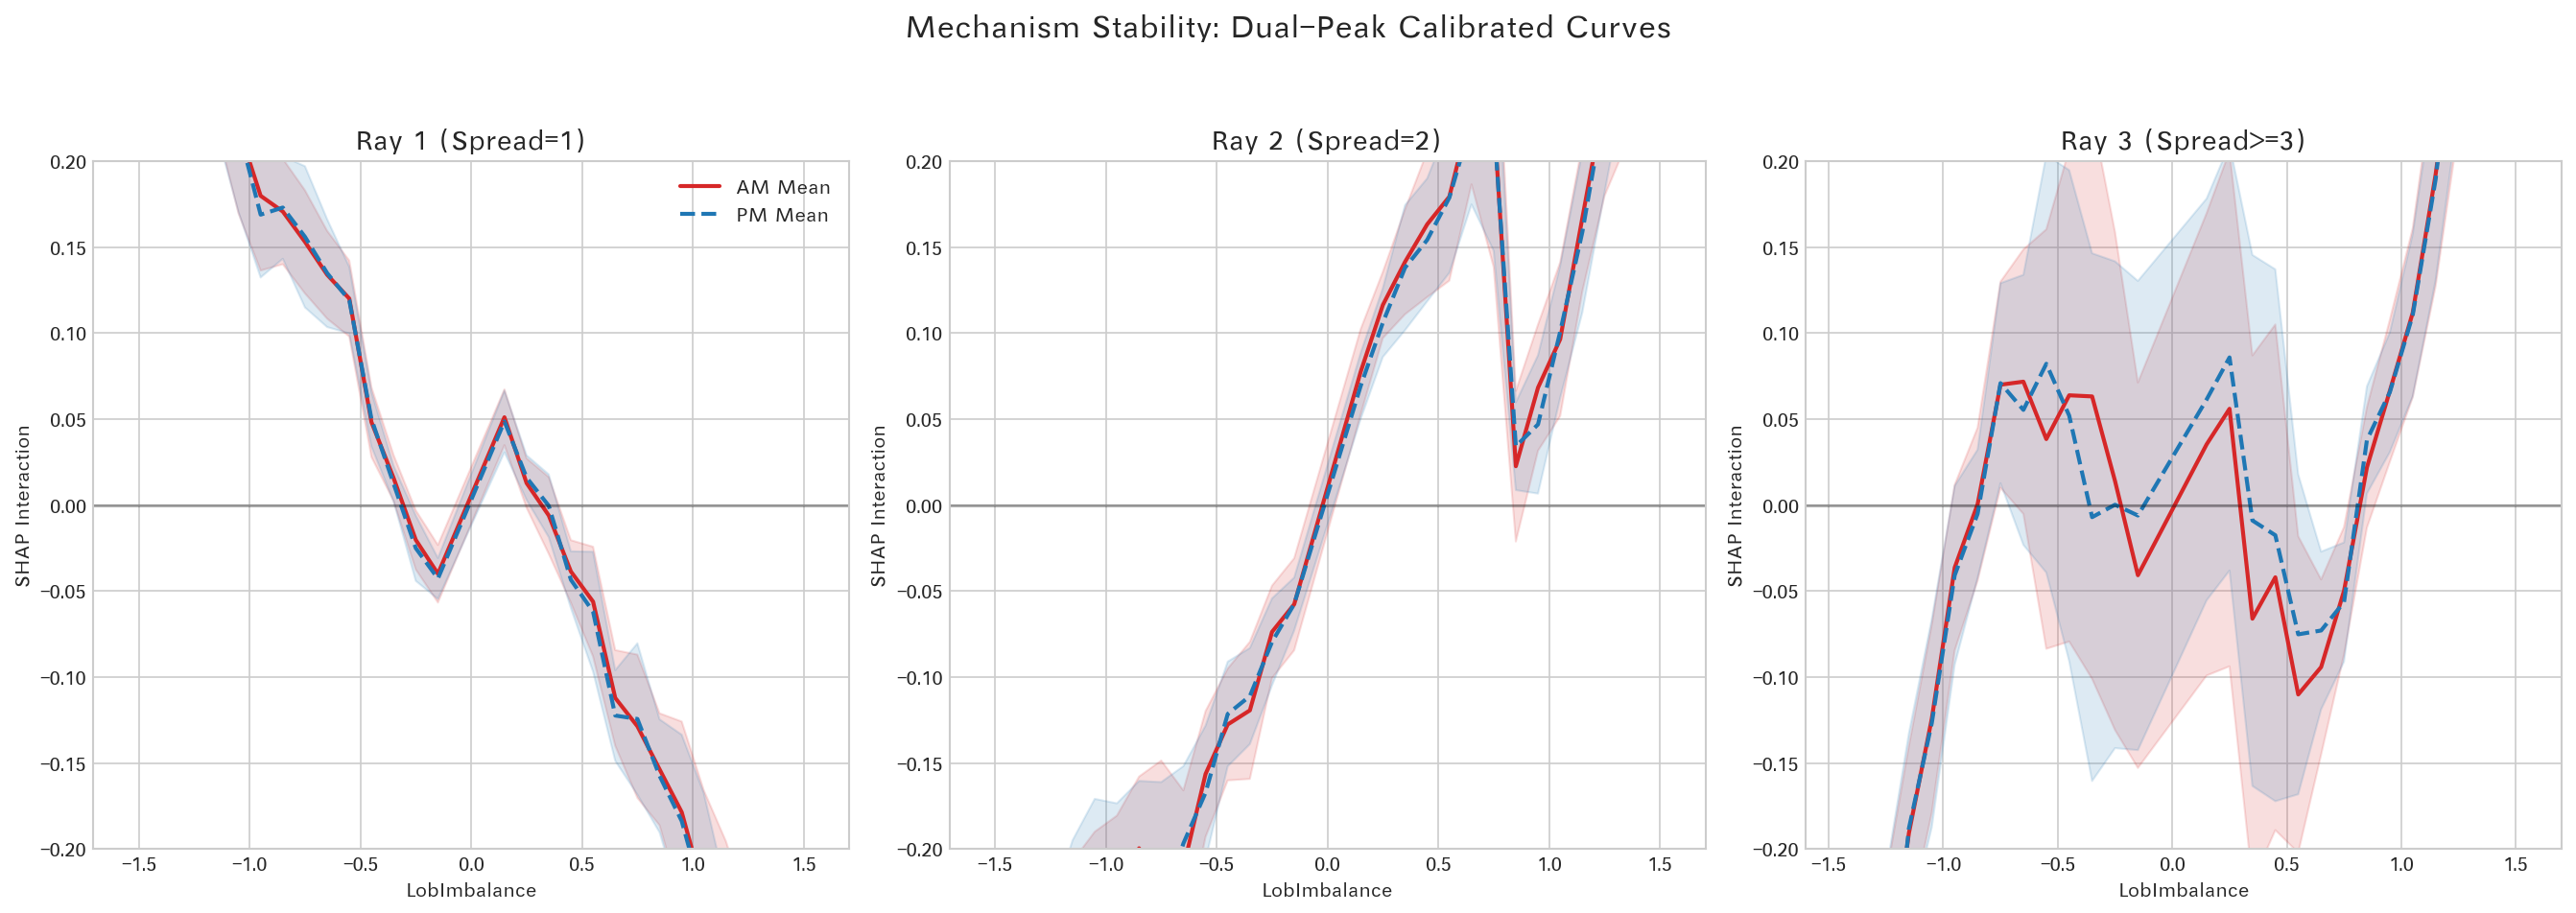


[Analysis Result]
   Ray 1 (Spread=1): AM/PM Correlation = 0.9998
   Ray 2 (Spread=2): AM/PM Correlation = 0.9985
   Ray 3 (Spread>=3): AM/PM Correlation = 0.9939


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import datetime
from scipy.signal import find_peaks
from scipy.stats import sem

# ================= 配置 =================
DPI = 150
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Hei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False

# ================= 1. 数据加载 =================
def find_project_root(current_path, marker='results'):
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)): return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError()
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
except:
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB-Spread-Regime'

DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time.parquet')
SHAP_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time_shap.npy')
FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 
    'Depth_Change', 'LobImbalance', 'DeepLobImbalance', 
    'Relative_Spread', 'Micro_Mid_Spread', 'PastReturn', 
    'Lambda', 'Volatility', 'AutoCov'
]

print(">>> Loading Data...")
df = pd.read_parquet(DATA_PATH)
shap_values_all = np.load(SHAP_PATH)
if 'Time' in df.columns: df['Time'] = pd.to_datetime(df['Time'])

idx_x = FEATURE_COLS.index('LobImbalance')
idx_y = FEATURE_COLS.index('Micro_Mid_Spread')
df['SHAP_Interaction'] = shap_values_all[:, idx_x, idx_y] * 2

# ================= 2. 核心算法：双峰智能校准 (Dual-Peak Calibration) =================
print("\n>>> Executing Dual-Peak Calibration...")

# 1. 计算原始比值 (Slope Proxy)
mask_valid = df['LobImbalance'].abs() > 0.1
df_rays = df[mask_valid].copy()
df_rays['Raw_Ratio'] = (df_rays['Micro_Mid_Spread'] / df_rays['LobImbalance']).abs()

# 2. 生成高分辨率直方图 (仅聚焦于 0~2.5 的低值区，寻找 Spread=1)
hist_vals, bin_edges = np.histogram(df_rays['Raw_Ratio'], bins=500, range=(0, 2.5))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 3. 寻找显著峰值
# height: 要求峰值高度至少是最大峰的 20%
# distance: 峰之间至少隔开 10 个 bin
peaks, properties = find_peaks(hist_vals, height=np.max(hist_vals)*0.2, distance=10)
peak_locs = bin_centers[peaks]
peak_heights = hist_vals[peaks]

print(f"   [Detection] Found {len(peaks)} candidate peaks at: {peak_locs}")

# 4. 智能决策策略
# 我们假设 Spread=1 是数据中最主要的部分，因此它对应最高的峰（或最高的双峰）
# 按高度排序
sorted_idx = np.argsort(peak_heights)[::-1]
top_peaks = peak_locs[sorted_idx[:2]] # 取最高的两个
top_peaks.sort()

# 判断是否为“分裂的双峰”
# 判据：如果两个主峰距离很近（例如在 1.5倍 范围内），则认为是分裂的 Spread=1
is_dual_peak = False
base_slope = 0.0

if len(top_peaks) >= 2 and (top_peaks[1] < top_peaks[0] * 1.5):
    print("   [Diagnosis] Detected SPLIT PEAKS (Double Hump).")
    print(f"               Peak A: {top_peaks[0]:.4f}, Peak B: {top_peaks[1]:.4f}")
    # 取平均值作为真正的物理基准
    base_slope = np.mean(top_peaks)
    is_dual_peak = True
    print(f"   [Strategy ] Using AVERAGE as Base Slope: {base_slope:.4f}")
else:
    print("   [Diagnosis] Detected SINGLE DOMINANT PEAK.")
    base_slope = top_peaks[0] if len(top_peaks) > 0 else peak_locs[0]
    print(f"   [Strategy ] Using MAX PEAK as Base Slope: {base_slope:.4f}")

# 5. 可视化校准结果 (这步很重要，请检查弹出的图)
plt.figure(figsize=(10, 5), dpi=120)
plt.hist(df_rays['Raw_Ratio'], bins=500, range=(0, 2.5), color='lightgray', label='Data Density')
for p in peak_locs:
    plt.axvline(p, color='orange', linestyle=':', alpha=0.5, label='Candidate Peak')
plt.axvline(base_slope, color='red', linestyle='-', linewidth=2, label=f'Final Base ({base_slope:.3f})')

plt.title('Dual-Peak Calibration Verification')
plt.xlabel('Slope Proxy (Raw Ratio)')
plt.legend()
plt.show()

# ================= 3. 物理还原与分类 =================
# 计算缩放因子：把 Base 映射回物理的 0.01
scaling_factor = 0.01 / base_slope
df_rays['Physical_Spread'] = df_rays['Raw_Ratio'] * scaling_factor

# 四舍五入分类
df_rays['Tick_Count'] = (df_rays['Physical_Spread'] / 0.01).round().astype(int)

def assign_tick_ray(tick):
    if tick == 1: return 'Ray 1 (Spread=1)'
    elif tick == 2: return 'Ray 2 (Spread=2)'
    elif tick >= 3: return 'Ray 3 (Spread>=3)'
    else: return 'Noise'

df_rays['Ray_Group'] = df_rays['Tick_Count'].apply(assign_tick_ray)

print("\n   [Distribution] Final Group Counts:")
print(df_rays['Ray_Group'].value_counts())

# ================= 4. 曲线与方差分析 (AM vs PM) =================
print("\n>>> Generating Mechanism Curves...")

# 细分箱
bins = np.linspace(-2.0, 2.0, 41)
df_rays['Imb_Bin'] = pd.cut(df_rays['LobImbalance'], bins=bins)
df_rays['Bin_Center'] = df_rays['Imb_Bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

# AM/PM 切分
times = df_rays['Time'].dt.time
mask_am = times <= datetime.time(11, 30)
mask_pm = times >= datetime.time(13, 0)
df_rays['Session'] = np.where(mask_am[df_rays.index], 'AM', 
                     np.where(mask_pm[df_rays.index], 'PM', 'Other'))

def get_curve_stats(sub_df):
    stats = sub_df.groupby('Bin_Center')['SHAP_Interaction'].agg(['mean', 'std', 'count'])
    return stats[stats['count'] > 5]

groups = ['Ray 1 (Spread=1)', 'Ray 2 (Spread=2)', 'Ray 3 (Spread>=3)']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=DPI)

for i, group in enumerate(groups):
    ax = axes[i]
    df_g = df_rays[df_rays['Ray_Group'] == group]
    
    stats_am = get_curve_stats(df_g[df_g['Session'] == 'AM'])
    stats_pm = get_curve_stats(df_g[df_g['Session'] == 'PM'])
    
    # 绘制曲线
    if not stats_am.empty:
        ax.plot(stats_am.index, stats_am['mean'], color='#D62728', label='AM Mean', linewidth=2)
        ax.fill_between(stats_am.index, 
                        stats_am['mean'] - stats_am['std'], 
                        stats_am['mean'] + stats_am['std'], 
                        color='#D62728', alpha=0.15)
    
    if not stats_pm.empty:
        ax.plot(stats_pm.index, stats_pm['mean'], color='#1F77B4', label='PM Mean', linewidth=2, linestyle='--')
        ax.fill_between(stats_pm.index, 
                        stats_pm['mean'] - stats_pm['std'], 
                        stats_pm['mean'] + stats_pm['std'], 
                        color='#1F77B4', alpha=0.15)
    
    ax.set_title(group, fontsize=14, fontweight='bold')
    ax.set_xlabel("LobImbalance")
    ax.set_ylabel("SHAP Interaction")
    ax.axhline(0, color='black', alpha=0.3)
    ax.set_ylim(-0.2, 0.2)
    
    if i == 0: ax.legend()

plt.suptitle("Mechanism Stability: Dual-Peak Calibrated Curves", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 输出文字结论
print("\n[Analysis Result]")
for group in groups:
    df_g = df_rays[df_rays['Ray_Group'] == group]
    stats_am = get_curve_stats(df_g[df_g['Session'] == 'AM'])
    stats_pm = get_curve_stats(df_g[df_g['Session'] == 'PM'])
    
    common = stats_am.index.intersection(stats_pm.index)
    if len(common) > 5:
        corr = np.corrcoef(stats_am.loc[common, 'mean'], stats_pm.loc[common, 'mean'])[0,1]
        print(f"   {group}: AM/PM Correlation = {corr:.4f}")

>>> Loading Data...
   [Calibration] Base Slope (Spread=1) Peak found at: 0.1375


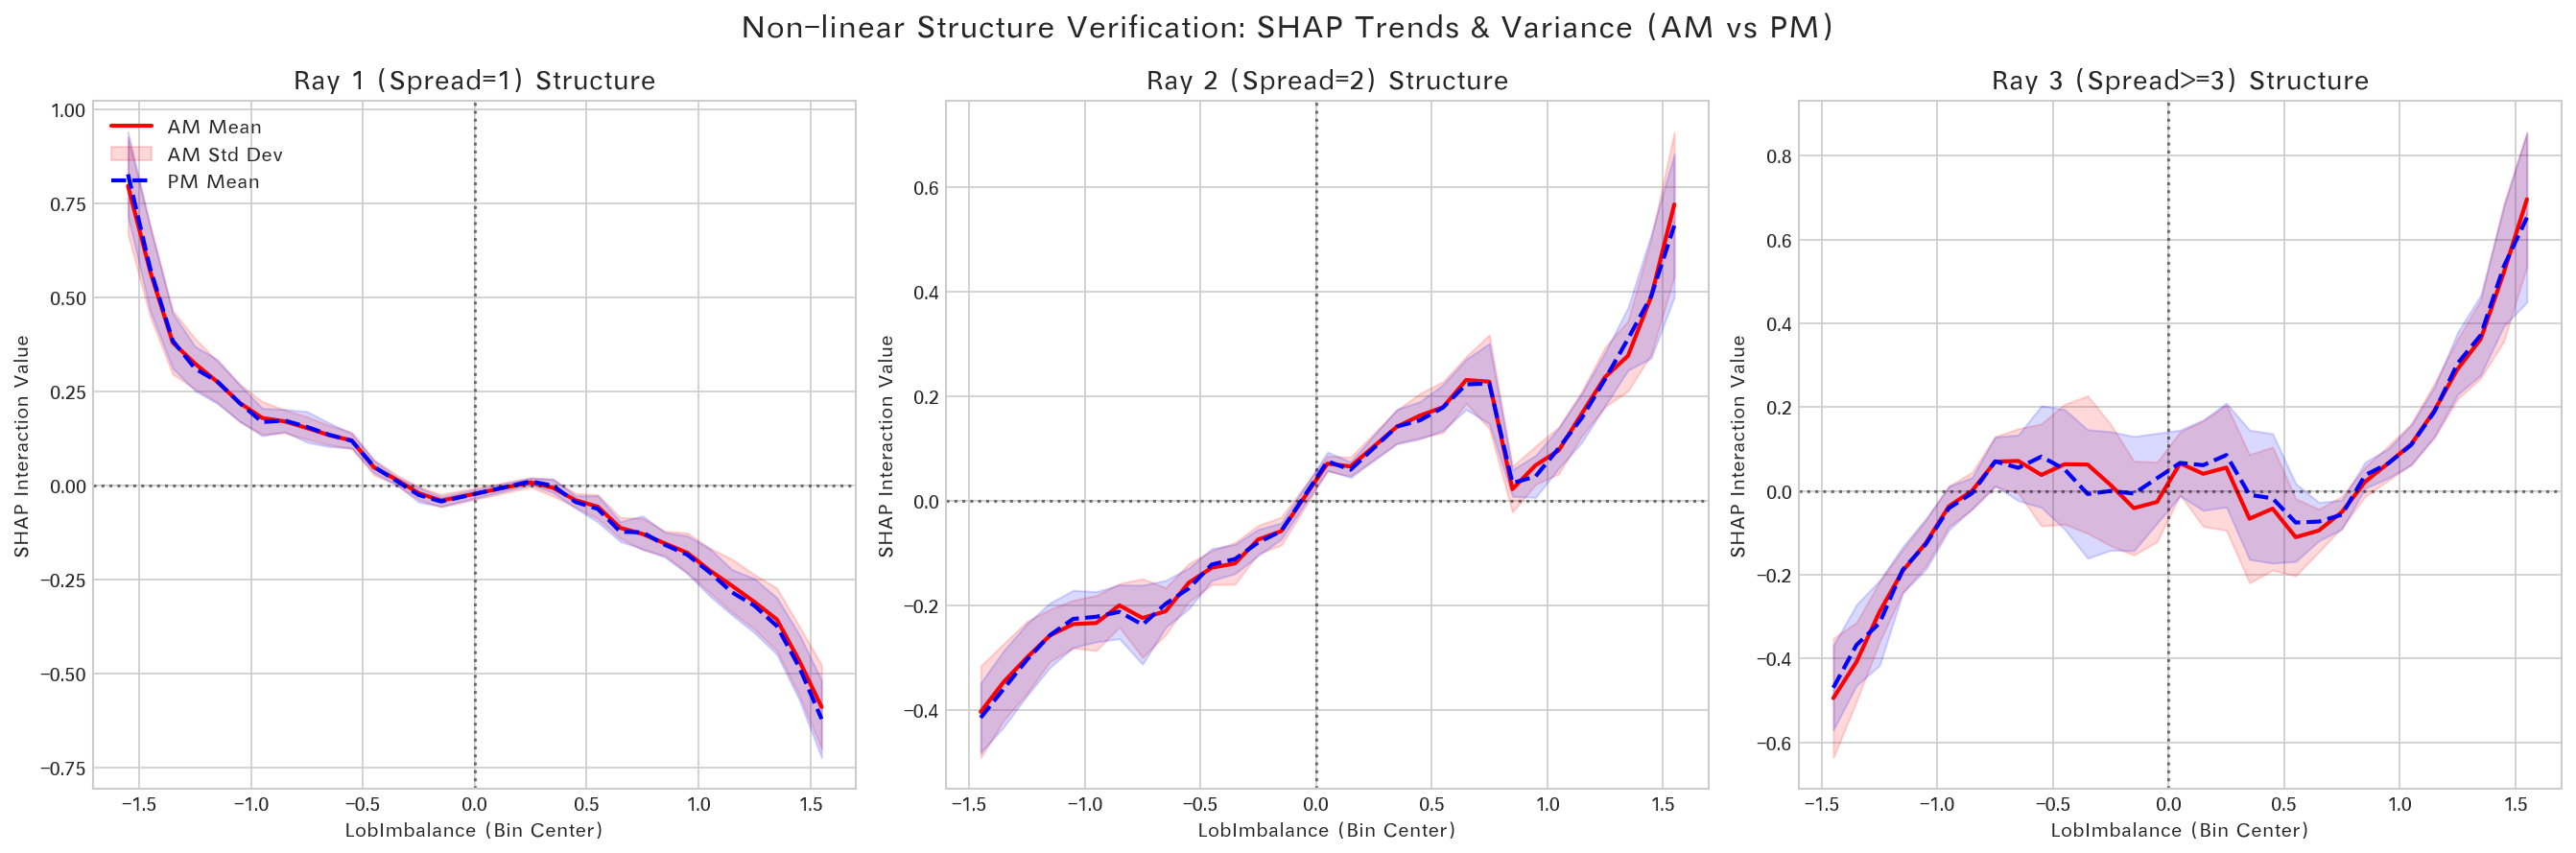


>>> Quantitative Check for Curves:
   Ray 1 (Spread=1): Curve Correlation (AM vs PM) = 0.9998
   Ray 2 (Spread=2): Curve Correlation (AM vs PM) = 0.9985
   Ray 3 (Spread>=3): Curve Correlation (AM vs PM) = 0.9940


In [19]:
print(">>> Loading Data...")
df = pd.read_parquet(DATA_PATH)
shap_values_all = np.load(SHAP_PATH)
if 'Time' in df.columns: df['Time'] = pd.to_datetime(df['Time'])

idx_x = FEATURE_COLS.index('LobImbalance')
idx_y = FEATURE_COLS.index('Micro_Mid_Spread')
df['SHAP_Interaction'] = shap_values_all[:, idx_x, idx_y] * 2

# ================= 2. 射线分类 (Deterministic Base Method) =================
# 计算斜率代理变量
mask_valid = df['LobImbalance'].abs() > 0.05
df_rays = df[mask_valid].copy()
df_rays['Slope_Proxy'] = (df_rays['Micro_Mid_Spread'] / df_rays['LobImbalance']).abs()

# 自动寻找基准斜率 (Peak of Histogram)
hist_vals, bin_edges = np.histogram(df_rays['Slope_Proxy'], bins=200, range=(0, 5))
peak_idx = np.argmax(hist_vals)
base_slope = (bin_edges[peak_idx] + bin_edges[peak_idx+1]) / 2
print(f"   [Calibration] Base Slope (Spread=1) Peak found at: {base_slope:.4f}")

def assign_ray(val):
    if (0.6 * base_slope) <= val <= (1.4 * base_slope): return 'Ray 1 (Spread=1)'
    if (1.6 * base_slope) <= val <= (2.4 * base_slope): return 'Ray 2 (Spread=2)'
    if val > (2.6 * base_slope): return 'Ray 3 (Spread>=3)'
    return 'Noise'

df_rays['Ray_Group'] = df_rays['Slope_Proxy'].apply(assign_ray)

# ================= 3. 曲线与方差分析 (Curve Analysis) =================
# 定义 LobImbalance 的分箱 (横轴)
# 范围取 -2 到 2 (覆盖绝大多数样本)，分 40 个 Bin
bins = np.linspace(-2.0, 2.0, 41)
df_rays['Imb_Bin'] = pd.cut(df_rays['LobImbalance'], bins=bins)
# 取 Bin 的中心点作为绘图用的 x 坐标
df_rays['Bin_Center'] = df_rays['Imb_Bin'].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

# 区分 AM/PM
times = df_rays['Time'].dt.time
mask_am = times <= datetime.time(11, 30)
mask_pm = times >= datetime.time(13, 0)
df_rays['Session'] = np.where(mask_am[df_rays.index], 'AM', 
                     np.where(mask_pm[df_rays.index], 'PM', 'Other'))

# 核心聚合函数
def get_curve_stats(sub_df):
    stats = sub_df.groupby('Bin_Center')['SHAP_Interaction'].agg(['mean', 'std', 'count', sem])
    # 过滤掉样本太少的点，避免方差估计不准
    return stats[stats['count'] > 10]

# 绘图逻辑
groups = ['Ray 1 (Spread=1)', 'Ray 2 (Spread=2)', 'Ray 3 (Spread>=3)']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=DPI)

for i, group in enumerate(groups):
    ax = axes[i]
    df_g = df_rays[df_rays['Ray_Group'] == group]
    
    # 分别计算 AM 和 PM 的曲线
    stats_am = get_curve_stats(df_g[df_g['Session'] == 'AM'])
    stats_pm = get_curve_stats(df_g[df_g['Session'] == 'PM'])
    
    # 绘制 AM (红色系)
    ax.plot(stats_am.index, stats_am['mean'], color='red', label='AM Mean', linewidth=2)
    ax.fill_between(stats_am.index, 
                    stats_am['mean'] - stats_am['std'], 
                    stats_am['mean'] + stats_am['std'], 
                    color='red', alpha=0.15, label='AM Std Dev') # 用 Std 代表数据本身的离散度
    
    # 绘制 PM (蓝色系)
    ax.plot(stats_pm.index, stats_pm['mean'], color='blue', label='PM Mean', linewidth=2, linestyle='--')
    ax.fill_between(stats_pm.index, 
                    stats_pm['mean'] - stats_pm['std'], 
                    stats_pm['mean'] + stats_pm['std'], 
                    color='blue', alpha=0.15)
    
    # 装饰
    ax.set_title(f"{group} Structure", fontsize=14)
    ax.set_xlabel("LobImbalance (Bin Center)")
    ax.set_ylabel("SHAP Interaction Value")
    ax.axhline(0, color='black', linestyle=':', alpha=0.5)
    ax.axvline(0, color='black', linestyle=':', alpha=0.5)
    
    if i == 0: ax.legend(loc='upper left')

plt.suptitle("Non-linear Structure Verification: SHAP Trends & Variance (AM vs PM)", fontsize=16)
plt.tight_layout()
plt.show()

# ================= 4. 定量检验结论 =================
print("\n>>> Quantitative Check for Curves:")
for group in groups:
    df_g = df_rays[df_rays['Ray_Group'] == group]
    stats_am = get_curve_stats(df_g[df_g['Session'] == 'AM'])
    stats_pm = get_curve_stats(df_g[df_g['Session'] == 'PM'])
    
    # 计算两条曲线的相关性 (只计算重叠部分)
    common_idx = stats_am.index.intersection(stats_pm.index)
    if len(common_idx) > 5:
        corr = np.corrcoef(stats_am.loc[common_idx, 'mean'], stats_pm.loc[common_idx, 'mean'])[0,1]
        print(f"   {group}: Curve Correlation (AM vs PM) = {corr:.4f}")
    else:
        print(f"   {group}: Not enough overlap to calc correlation.")